### In this notebook we perform individual training.
In individual learning each base station has access only to it's private dataset.

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import random

import numpy as np
import torch

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset
    data_path_test=['../dataset/ElBorn_test.csv'], # test dataset
    test_size=0.2, # validation size 
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], # the target columns
    num_lags=10, # the number of past observations to feed as input

    
    filter_bs=None, # whether to use a single bs for training. It will be changed dynamically
    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping

    
    criterion='mse', # optimization criterion, mse or l1
    epochs=150, # the number of maximum epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    early_stopping=True, # whether to use early stopping
    patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization
    
    plot_history=True, # plot loss history

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

> You can define the base station to perform train on the filter_bs parameter and use it in block 12 or you can define the base station to block 12 explicitly 

In [7]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/full_dataset.csv', data_path_test=['../dataset/ElBorn_test.csv'], test_size=0.2, targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], num_lags=10, filter_bs=None, identifier='District', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=None, criterion='mse', epochs=150, lr=0.001, optimizer='adam', batch_size=128, early_stopping=True, patience=50, max_grad_norm=0.0, reg1=0.0, reg2=0.0, plot_history=True, cuda=True, seed=0, assign_stats=None, use_time_features=False)



In [8]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [9]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [10]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
seed_all()

### The preprocessing pipeline performed here for the base station specified in filter_bs argument
Preprocessing inlcudes:
1. NaNs Handling
2. Outliers Handling
3. Scaling Data
4. Generating time lags
5. Generating and importing exogenous data as features (time, statistics) (if applied)

In [12]:
def make_preprocessing(filter_bs=None):
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path, filter_data=filter_bs)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
                                             scaler=args.x_scaler, identifier=args.identifier)
    # scale y
    y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
                                             scaler=args.y_scaler, identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [13]:
# here exogenous_data_train and val are None.
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing(
    filter_bs="LesCorts"
)

INFO logger 2022-10-24 16:30:35,446 | data_utils.py:28 | Reading LesCorts's data...
INFO logger 2022-10-24 16:30:35,511 | data_utils.py:395 | 	Total number of samples:  6892
INFO logger 2022-10-24 16:30:35,511 | data_utils.py:396 | 	Number of samples for training: 5514
INFO logger 2022-10-24 16:30:35,512 | data_utils.py:397 | 	Number of samples for validation:  1378


In [14]:
X_train.head()

,rb_up_var_lag-10,rb_up_lag-10,rb_down_var_lag-10,rb_down_lag-10,mcs_up_var_lag-10,mcs_up_lag-10,mcs_down_var_lag-10,mcs_down_lag-10,rnti_count_lag-10,up_lag-10,...,rb_down_var_lag-1,rb_down_lag-1,mcs_up_var_lag-1,mcs_up_lag-1,mcs_down_var_lag-1,mcs_down_lag-1,rnti_count_lag-1,up_lag-1,down_lag-1,District
time,,,,,,,,,,,,,,,,,,,,,
2019-01-12 17:32:00,1.083682e-08,0.036054,1.961025e-08,0.109670,0.493544,0.431702,0.459601,0.160269,0.210509,0.017705,...,1.974816e-08,0.114193,0.572030,0.400005,0.460896,0.164719,0.212757,0.018888,0.131219,LesCorts
2019-01-12 17:34:00,1.061491e-08,0.030426,1.644211e-08,0.098938,0.527483,0.476772,0.392094,0.131085,0.200300,0.018282,...,1.791601e-08,0.105544,0.576015,0.445876,0.427184,0.145817,0.192432,0.014424,0.113276,LesCorts
2019-01-12 17:36:00,9.109702e-09,0.038901,1.761309e-08,0.106045,0.501063,0.471773,0.453949,0.152725,0.221468,0.019501,...,1.766410e-08,0.101075,0.640010,0.448971,0.387407,0.130386,0.173137,0.011194,0.101414,LesCorts
2019-01-12 17:38:00,5.813802e-09,0.026050,1.668480e-08,0.098968,0.499865,0.450949,0.382516,0.129036,0.183768,0.012594,...,1.963081e-08,0.114777,0.534812,0.414812,0.476978,0.171880,0.205545,0.023585,0.141225,LesCorts
2019-01-12 17:40:00,7.246522e-09,0.028981,1.721707e-08,0.102669,0.535319,0.429488,0.412994,0.139577,0.191964,0.013056,...,1.895823e-08,0.107131,0.547422,0.456544,0.448805,0.157300,0.181567,0.022127,0.125069,LesCorts


In [15]:
y_train.head()

,rnti_count,rb_down,rb_up,down,up,District
time,,,,,,
2019-01-12 17:32:00,0.192432,0.105544,0.033785,0.113276,0.014424,LesCorts
2019-01-12 17:34:00,0.173137,0.101075,0.025216,0.101414,0.011194,LesCorts
2019-01-12 17:36:00,0.205545,0.114777,0.060088,0.141225,0.023585,LesCorts
2019-01-12 17:38:00,0.181567,0.107131,0.042592,0.125069,0.022127,LesCorts
2019-01-12 17:40:00,0.175900,0.101726,0.023463,0.107920,0.011213,LesCorts


In [16]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

### Postprocessing Stage

In this stage we transform data in a way that can be fed into ML algorithms.

In [28]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    # centralized (all) learning specific
    if not args.filter_bs and exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [18]:
X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

In [19]:
X_train[:2]

array([[[[1.08368177e-08],
         [3.60536501e-02],
         [1.96102530e-08],
         [1.09670356e-01],
         [4.93544310e-01],
         [4.31701750e-01],
         [4.59600508e-01],
         [1.60269260e-01],
         [2.10509062e-01],
         [1.77047513e-02],
         [1.29703119e-01]],

        [[1.06149072e-08],
         [3.04260999e-02],
         [1.64421117e-08],
         [9.89375487e-02],
         [5.27482629e-01],
         [4.76772249e-01],
         [3.92093986e-01],
         [1.31084532e-01],
         [2.00299725e-01],
         [1.82819255e-02],
         [9.46676582e-02]],

        [[9.10970233e-09],
         [3.89005616e-02],
         [1.76130861e-08],
         [1.06044851e-01],
         [5.01062572e-01],
         [4.71772611e-01],
         [4.53948647e-01],
         [1.52724519e-01],
         [2.21467718e-01],
         [1.95014086e-02],
         [1.11105040e-01]],

        [[5.81380233e-09],
         [2.60500330e-02],
         [1.66847958e-08],
         [9.89684388e-

In [20]:
y_train[:2]

array([[0.19243199, 0.1055439 , 0.03378513, 0.11327641, 0.01442373],
       [0.17313728, 0.10107498, 0.02521631, 0.10141373, 0.01119418]],
      dtype=float32)

In [21]:
len(X_train), len(X_val)

(5504, 1368)

### Define the input dimensions for the model architecture

In [22]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

### Initialize the model for training

In [23]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [24]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

11 0


In [25]:
model

LSTM(
  (lstm): LSTM(11, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
)

### The fit function used to train the model specified above

In [26]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[8, 3, 1, 10, 9], # the indices of our targets in X
        log_per=1):
    
    # get exogenous data (if any)
    if exogenous_data_train is not None and len(exogenous_data_train) > 1:
        exogenous_data_train = exogenous_data_train["all"]
        exogenous_data_val = exogenous_data_val["all"]
    elif exogenous_data_train is not None and len(exogenous_data_train) == 1:
        cid = next(iter(exogenous_data_train.keys()))
        exogenous_data_train = exogenous_data_train[cid]
        exogenous_data_val = exogenous_data_val[cid]
    else:
        exogenous_data_train = None
        exogenous_data_val = None
    num_features = len(X_train[0][0])
    
    # to torch loader
    train_loader = to_torch_dataset(X_train, y_train,
                                    num_lags=args.num_lags,
                                    num_features=num_features,
                                    exogenous_data=exogenous_data_train,
                                    indices=idxs,
                                    batch_size=args.batch_size, 
                                    shuffle=False)
    val_loader = to_torch_dataset(X_val, y_val, 
                                  num_lags=args.num_lags,
                                  num_features=num_features,
                                  exogenous_data=exogenous_data_val,
                                  indices=idxs,
                                  batch_size=args.batch_size,
                                  shuffle=False)
    
    # train the model
    model = train(model, 
                  train_loader, val_loader,
                  epochs=args.epochs,
                  optimizer=args.optimizer, lr=args.lr,
                  criterion=args.criterion,
                  early_stopping=args.early_stopping,
                  patience=args.patience,
                  plot_history=args.plot_history, 
                  device=device, log_per=log_per)
    
    return model

INFO logger 2022-10-24 16:30:45,941 | train_utils.py:97 | Epoch 1 [Train]: loss 0.009817008240429987, mse: 0.006684846244752407, rmse: 0.08176090902596672, mae 0.050114553421735764, r2: 0.301586244673529, nrmse: 1.6128628334541237
INFO logger 2022-10-24 16:30:45,944 | train_utils.py:99 | Epoch 1 [Test]: loss 6.256589961472398e-05, mse: 0.007847568020224571, rmse: 0.0885865002143361, mae 0.05763064697384834, r2: -203.55665968299832, nrmse: 11.073628867583354
INFO logger 2022-10-24 16:30:45,944 | helpers.py:148 | Validation loss decreased (inf --> 0.000063). Caching model ...
INFO logger 2022-10-24 16:30:46,461 | train_utils.py:97 | Epoch 2 [Train]: loss 0.005097735968288468, mse: 0.0034416825510561466, rmse: 0.058665855069675296, mae 0.03914261981844902, r2: 0.47421794643750276, nrmse: 1.560140873398426
INFO logger 2022-10-24 16:30:46,462 | train_utils.py:99 | Epoch 2 [Test]: loss 3.155781455169165e-05, mse: 0.0039516836404800415, rmse: 0.06286241834737223, mae 0.044917769730091095, r2:

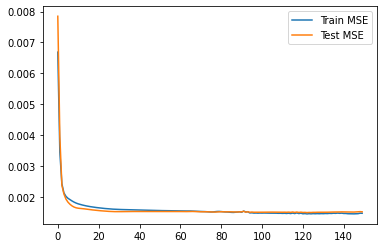

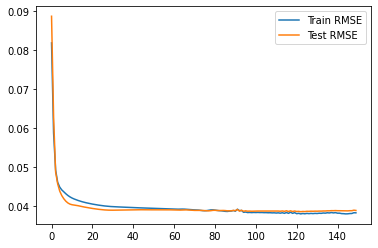

INFO logger 2022-10-24 16:31:59,373 | train_utils.py:140 | Best Loss: 1.1736776978281267e-05, Best epoch: 150


In [27]:
trained_model = fit(model, X_train, y_train, X_val, y_val)